In [ ]:
import numpy as np
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import conda
import os
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
from mpl_toolkits.basemap import Basemap

In [ ]:
def read_sql(database, table, mode='all', sql_query = None):
    
    connect = pymysql.Connect(host='192.168.31.200' ,
                         port =3306,
                         user='root', 
                         passwd = 'Alldo807!', 
                         db = database)
    
    if mode == "all":
        data = pd.read_sql(sql = 'select * from %s'%table, con = connect)
    elif mode == "top100":
        data = pd.read_sql(sql = 'select * from %s limit 100'%table, con = connect)
    elif mode == "sql" and sql_query:
        data = pd.read_sql(sql = sql_query , con = connect)

    return data

In [ ]:
def plotmap(point_dic):    
    plt.figure(figsize=(20,20))    
    meridians = np.arange(0.,360.,2.5)
    parallels = np.arange(0.,90,2.5) 
    m = Basemap(projection='gall', llcrnrlat=29, llcrnrlon=115,urcrnrlat=35,urcrnrlon=120)
    m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)    
    for key,val in point_dic.items():
        longs,lats = val['longitude'],val['latitude']
        x,y = m(np.array(longs),np.array(lats))
        m.scatter(x,y,s=10,label=key)
    plt.legend(loc=1)
    plt.show()

## 交调站

In [ ]:
traffic_flow_station_data = read_sql(database='botgodata',table='t_trff_flow_station_data', mode='top100')

In [ ]:
traffic_flow_station_position = read_sql(database='botgodata',table='t_trff_flow_station_location')
valid_positions = traffic_flow_station_position[traffic_flow_station_position['longitude']>0]
# print("longs")
# print(valid_positions['longitude'].min(),valid_positions['longitude'].max())
# print("lats")
# print(valid_positions['latitude'].min(),valid_positions['latitude'].max())
point_dic = {"traffic_flow_station":valid_positions}

plotmap(point_dic)

In [ ]:
traffic_flow_station_data.columns

In [ ]:
traffic_flow_station_data.head(10)

## 收费站

In [ ]:
toll_station_position = read_sql(database='botgodata',table='t_toll_station')

In [ ]:
valid_positions = toll_station_position[toll_station_position['Gd_longitude']>0]
valid_positions['longitude'] = valid_positions['Gd_longitude']
valid_positions['latitude'] = valid_positions['Gd_latitude']

In [ ]:
len(valid_positions),len(toll_station_position)

In [ ]:
point_dic['toll_gate'] = valid_positions
    
plotmap(point_dic)

# 完蛋，没有摄像头数据

# 好吧，编数据，一本正经......
## 先编个车辆产生器

In [ ]:
def in_vehicle_generator():
    while True:
        num_cars = np.random.randint(0,5)
#         velocities = np.random.randint(0,140,size=num_cars)
        velocities = np.random.choice([30,50,80,100,120],p=[0.2]*5,size=num_cars)
        yield (num_cars,velocities)

def out_vehicle_generator(max_num):
    while True:
        num_cars = np.random.randint(0,max_num)
        velocities = np.random.choice([30,50,80,100,120],p=[0.2]*5,size=num_cars)
        yield (num_cars,velocities)

## 假设取了1km路，路的两端正好两个摄像头，simulate 50 次

$$speed_{avg} = mean(speed_{in},speed_{out}) $$


$$num_{total} => count \space all \space  the \space vehicles $$


$$ density = \frac{num_{total}}{length} $$

if $density$ > $density_{critical}$ or $speed$ < $speed{critical}$:
    
   Congestion warning !!


In [ ]:
total_num = 0
avg_speed = 0
for i in range(50):
    p1 = np.random.uniform()
    p2 = np.random.uniform()
    num_cars_in, num_cars_out = 0,0
    if p1>0.3:
        num_cars_in,in_velocities = next(in_vehicle_generator())
        total_num += num_cars_in
    if p2>0.3 and total_num:
        num_cars_out,out_velocities = next(out_vehicle_generator(total_num))
        total_num -= num_cars_out
#     print("in_out",num_cars_in,num_cars_out)
    if num_cars_in or num_cars_out:
        avg_speed = np.mean(np.concatenate([in_velocities,out_velocities]))
    if (avg_speed<50 or total_num>8):
        print("congestion warning!!",total_num,avg_speed)
    else:
#         print("total num of vehicles",total_num)
        print(total_num,avg_speed)

## 收费站数据探索

In [ ]:
in_fname = '../data/toll_in_data.csv'
out_fname = '../data/toll_out_data.csv'

In [ ]:
toll_in_data = pd.read_csv(in_fname,parse_dates=['OPERATEON'])
toll_out_data = pd.read_csv(out_fname,parse_dates=['INOPERATEON'])

In [ ]:
toll_in_data['OPERATEON'].min()

In [ ]:
# toll_in_data[toll_in_data['OPERATEON']<'2018-01-11 00:01:50']['OPERATEON']

In [ ]:
toll_in_data.head(10)

In [ ]:
toll_in_data.columns

In [ ]:
toll_out_data.head(10)

In [ ]:
print(list(toll_out_data.columns))

In [ ]:
'STATIONID' in toll_out_data.columns

## 标识站

In [ ]:
check_fname = "../data/check_station.csv"


In [ ]:

names = ['Id','ChkStaID','CamID','listID',
                     'oprDT','VehPlate','BigImage',
                    'BinaryImage','RouteFlag','Updated','Uploaded','SmallImage']
check_data = pd.read_csv(check_fname,header=None,encoding='gbk',names=names)

In [ ]:
check_data['oprDT'] = check_data['oprDT'].astype('datetime64[ns]')

In [ ]:
check_data['oprDT'].dtype

In [ ]:
check_data.head(10)

## 高德地图数据 (拥堵实时修正)

In [ ]:
import numpy as np
import pandas as pd
import pymysql
import datetime as dt



In [ ]:
TIME_INTERVAL = 5 # minutes
CAMERA_LENGTH = 0.05 # km


def camera_judge_congestion(camera_id,debug=True):
    #### connect to camera database
    #### judge if there is a congestion 
    if debug:
        return 1
    else:
        pass
     
    

def congestion_rectify_main(debug=True):
    
    if debug:
        s1 = '2017-12-11 22:53:21'
        s2 = '2017-12-11 23:03:21'
        camera_infos = []
    else:
        s2 = dt.datetime.now()
        s1 = str(s2 - dt.timedelta(minutes=TIME_INTERVAL))
        s2 = str(s2)
        
    ### 建立连接，测试数据库 192.168.31.200:3306,  db: botgodat
    connect = pymysql.Connect(host='192.168.31.200' ,
                         port =3306,
                         user='root', 
                         passwd = 'Alldo807!', 
                         db = 'godb')
    cur = connect.cursor()
    
    ### 两个数据表： t_gaode_trff_congestion &  t_gd_congest 取前者试验, 两个时间 insert_time & create_time 存在时间差2min
    cong_query = "SELECT * FROM t_gaode_trff_congestion WHERE insert_time BETWEEN '%s' AND '%s'"%(s1,s2)
    congest_info = pd.read_sql(cong_query,connect)
    
    camera_ids = []
    for ind,entry in congest_info.iterrows():
        if entry.road_number1 == entry.road_number2:
            start_stake = entry.stake_number1 - 0.5*CAMERA_LENGTH
            end_stake = entry.stake_number2 + 0.5*CAMERA_LENGTH
            print(start_stake,end_stake)
            
    ### 选择在拥堵范围内的摄像头
            if debug:
                camera_query = "SELECT * FROM t_camera WHERE (highway_number = '{}') AND area LIKE '%干线%' \
                                and (stake_number between {} and {})".format(entry.road_number1, start_stake,end_stake)
                camera_info = pd.read_sql(camera_query,connect)
                camera_infos.append(camera_info)
                camera_ids = (list(camera_infos['c_id']),list(camera_infos['stake_number'])
                 
            else:
#                 camera_query = "SELECT c_id,stake_number FROM t_camera WHERE (highway_number = '{}') AND area LIKE '%干线%' \
#                                 and (stake_number between {} and {})".format(entry.road_number1, start_stake,end_stake)
#                 cur.execute(camera_query)
#                 camera_ids = cur.fetchall()
                pass
            for id_,loc in camera_ids:
                
                is_congest = camera_judge_congestion(id_)
                
                if not is_congest:
                    entry['xys']
                    
                        
                              
                    
                
            
            
                
    
            
    return congest_info,camera_infos 
    
cong_info,camera_info = congestion_rectify_main()

In [ ]:
camera_info[0].c_id

In [ ]:
camera_info[0].stake

In [ ]:
cong_info

In [ ]:
coords = cong_info['gd_xys'][0].split(';')
xs = [float(x.split(',')[0]) for x in coords[:]]
ys = [float(y.split(',')[1]) for y in coords[:]]



In [ ]:
xs

In [ ]:
plt.figure(figsize=(10,10))    
meridians = np.arange(0.,360.,0.5)
parallels = np.arange(0.,90,0.2) 
m = Basemap(projection='gall', llcrnrlat=33.1, llcrnrlon=115.9,urcrnrlat=33.28,urcrnrlon=116.1)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10) 
x,y = m(np.array(xs),np.array(ys))
m.plot(x,y)
m.plot(x[:-5],y[:-5],c='r')
m.plot(x[:-15],y[:-15],c='g')
plt.show()

In [ ]:
connect = pymysql.Connect(host='192.168.31.200' ,
                     port =3306,
                     user='root', 
                     passwd = 'Alldo807!', 
                     db = 'godb')

### 两个数据表： t_gaode_trff_congestion &  t_gd_congest 取前者试验, 两个时间 insert_time & create_time 存在时间差2min
query = "SELECT c_id,stake_number FROM t_camera WHERE (highway_number = '{}') AND area LIKE '%干线%' \
        and (stake_number between {} and {})".format('G36', 280,290)  


cur = connect.cursor()
cur.execute(query)
results = cur.fetchall()
results

In [ ]:
for id_,loc in results:
    print(id_,loc)

In [ ]:
list(results)[0][0]

In [ ]:
[].extend(results)

In [ ]:
results

# 高级算法研究

## 网络模型 + Kirchhoff's law

In [1]:
import networkx as nx
import numpy as np

In [2]:
# adj = np.array([[1,1,0,1,1],[0,1,1,0,0],[0,0,0,1,0],[0,0,0,1,0],[0,0,0,1,1]])

adj = np.array([[0,1,0,1,1],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,0],[0,0,0,1,0]])

In [3]:
graph = nx.from_numpy_array(adj,create_using=nx.DiGraph())
# graph= graph.to_directed()
pos=nx.shell_layout(graph)

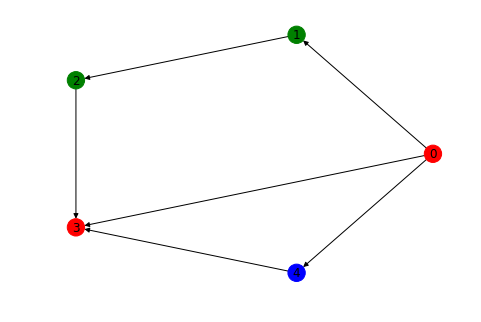

In [8]:
nx.draw(graph,pos,with_labels = True,node_color=['r','g','g','r','b'])

In [5]:
len(graph.edges()),graph.edges()

(6, OutEdgeView([(0, 1), (0, 3), (0, 4), (1, 2), (2, 3), (4, 3)]))

In [6]:
incidence_mat = nx.incidence_matrix(graph,oriented=True).toarray()
incidence_mat

array([[-1., -1., -1.,  0.,  0.,  0.],
       [ 1.,  0.,  0., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  1.,  1.],
       [ 0.,  0.,  1.,  0.,  0., -1.]])

In [7]:
in_out = np.array([-8,1,1,5,1]).reshape(-1,1)

array([[-8],
       [ 1],
       [ 1],
       [ 5],
       [ 1]])

$$ A x = y$$

$$A \in R ^{n\times{m}} \space when \space n<m$$

### 这是一个不定方程，需要提供摄像头流量来补充方程

### 因为道路有2个独立的圈，所以rank是6-2=4，需要补充两个摄像头数据

In [27]:
# known_flows = [2,2]
# known_cols = [1,4]

known_flows = [4,0]
known_cols = [1,5]

in_out = np.array([8,-1,-1,-5,-1]).reshape(-1,1)

def calcualte_flow(incidence_mat, nodal_flow, known_flows, known_cols):
    num_roads = incidence_mat.shape[1]
    print(np.linalg.matrix_rank(incidence_mat))
    output_flows = np.zeros(num_roads)
    known_flows = np.array(known_flows)
    known_cols = np.array(known_cols)
    y = -nodal_flow - incidence_mat[:,known_cols].dot(known_flows.reshape(-1,1))
    unknown_cols = np.setdiff1d(np.arange(num_roads),known_cols)
    A = incidence_mat[:,unknown_cols]
    output_flows[known_cols] = known_flows
    output_flows[unknown_cols] = (np.linalg.pinv(A).dot(y)).flatten()
    return output_flows
    
calcualte_flow(incidence_mat, in_out, known_flows,known_cols)

4


array([3., 4., 1., 2., 1., 0.])

#### New configuration

In [ ]:
adj = np.array([[0,1,0,1,1],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,0],[0,0,0,1,0]])

## 概率模型 —— 完全没有摄像头 (Markovian Model / Bayes Network)

In [ ]:
nx.draw(graph,pos,with_labels = True,node_color=['r','g','g','r','b'])

In [ ]:
congestion = read_sql(database='botgo_anhui',table='t_gaode_congestion', mode='top100')

In [ ]:
congestion['xys'].iloc[0]

In [ ]:
np.linalg.matrix_rank()

In [ ]:
A = np.array([[1,-1,0],[0,1,1],[-1,0,-1]])

A